In [1]:
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)
# Trouve les indexes des premieres 'n' valeurs minimales d'une matrice
min.nindex <- function(m, n=5) {
    i <- order(m)
    return(i[1:n])
}
cosinus.vm <- function(v,m) { 
    n <- sqrt(colSums(m^2)); 
    (v %*% m)/(n * sqrt(sum(v^2)))
}

colMeans.sparse <- function(m) {colSums(m)/colSums(m>0)}
rowMeans.sparse <- function(m) {rowSums(m)/rowSums(m>0)}
means.sparse <- function(v) {sum(v)/sum(v>0)}

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
m.na.t <- t(m.na)
m.t <- t(m)
m.sparse.t <- t(m.sparse)
library("recommenderlab")


Loading required package: arules

Attaching package: 'arules'

The following objects are masked from 'package:base':

    abbreviate, write

Loading required package: proxy

Attaching package: 'proxy'

The following object is masked from 'package:Matrix':

    as.matrix

The following objects are masked from 'package:stats':

    as.dist, dist

The following object is masked from 'package:base':

    as.matrix

Loading required package: registry


In [2]:
model.type <-c('UBCF','IBCF')
model.norm <- c('Z-score','center')
model.meth <- c('pearson', 'cosine', 'jaccard', 'euclidean')
model.n <- c(10,20,30,40,50)

In [3]:
posibilities<-expand.grid(model.type,model.norm,model.meth,model.n)

In [4]:
posibilities[27,]

,Var1,Var2,Var3,Var4
27,UBCF,center,jaccard,20


In [6]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.b], m.na[i.test.b])
    }


In [7]:
i.observed <- which(m > 0)
set.seed(1)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
total <- c()
for (possi in seq_len(dim(posibilities)[1])){
cv.b <- c()
type <- posibilities[possi,1]
norm <- posibilities[possi,2]
meth <- posibilities[possi,3]
n <- posibilities[possi,4]
for (i in seq_len(5)){
fold.number <- i
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false

## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
# Loading to pre-computed affinity data	 
affinity.data<- as(m.train.na,"realRatingMatrix")
if (type=='UBCF'){
Rec.model=Recommender(affinity.data, method=type,param=list(normalize = norm,method=meth,nn=n))
    } else {
Rec.model=Recommender(affinity.data, method=type,param=list(normalize = norm,method=meth,k=n))
}
pred <- predict(Rec.model,  affinity.data,n=1682)
# to display them
pred <- as(pred, "matrix")
m.train.na[is.na(m.train.na)]<-pred[is.na(m.train.na)]
m.train.na[!is.finite(m.train.na)]<- rep(rowMeans(m.train.na,na.rm=T),1682)[!is.finite(m.train.na)]
mae.temp <- mae(m.train.na[i.test.b], m.na[i.test.b])
cv.b <- c(cv.b,mae.temp)
    }
total<- c(total, mean(cv.b))
}

In [15]:
total

[1] 0.8327030 0.8874996 0.8327783 0.8881412 0.8336027 0.8753715 0.8335214
 [8] 0.8766303 0.8147538 0.8543784 0.8141261 0.8543784 0.8337987 0.8627435
[15] 0.8338764 0.8627734 0.8312186 0.9218915 0.8311792 0.9216664 0.8328692
[22] 0.8812861 0.8326637 0.8828278 0.8136786 0.8697574 0.8120045 0.8697574
[29] 0.8328873 0.8855629 0.8330117 0.8855988 0.8305101 0.9455476 0.8304381
[36] 0.9455599 0.8323794 0.8874178 0.8321860 0.8889363 0.8139583 0.8822861
[43] 0.8126092 0.8822861 0.8322851 0.9016637 0.8324329 0.9009769 0.8295935
[50] 0.9657647 0.8295126 0.9661389 0.8319925 0.8942243 0.8317852 0.8956900
[57] 0.8164207 0.8936693 0.8154047 0.8936693 0.8317527 0.9136453 0.8319579
[64] 0.9118633 0.8288330 0.9806007 0.8287028 0.9797567 0.8317322 0.9023053
[71] 0.8315250 0.9035103 0.8167259 0.9059941 0.8158792 0.9059941 0.8312011
[78] 0.9214035 0.8314450 0.9201646

In [7]:
i.observed <- which(m > 0)
set.seed(1)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))

to.plot <- c()
cv.b <- c()
for (i in seq_len(5)){
fold.number <- i
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false

## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
# Loading to pre-computed affinity data	 
affinity.data<- as(m.train.na,"realRatingMatrix")
Rec.model=Recommender(affinity.data, method="UBCF",param=list(normalize = "Center",method="jaccard",nn=20))
pred <- predict(Rec.model,  affinity.data,n=1682)
# to display them
pred <- as(pred, "matrix")
m.train.na[is.na(m.train.na)]<-pred[is.na(m.train.na)]
m.train.na[!is.finite(m.train.na)]<- rep(rowMeans(m.train.na,na.rm=T),1682)[!is.finite(m.train.na)]
mae.temp <- mae(m.train.na[i.test.b], m.na[i.test.b])
cv.b <- c(cv.b,mae.temp)
m.svd <- svd(m.train.na)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
    }


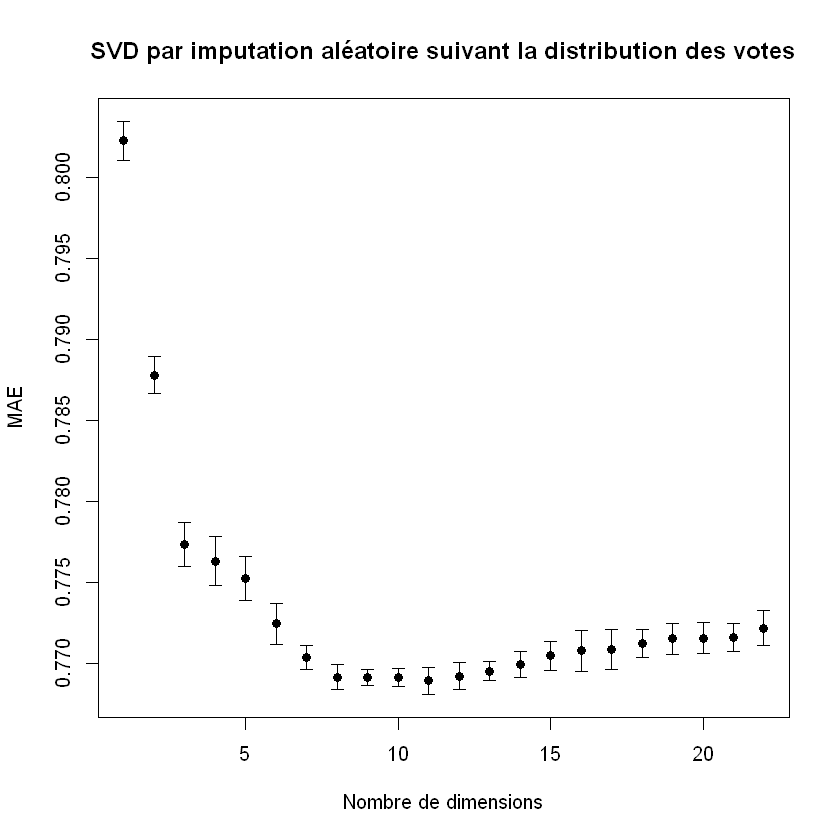

In [8]:
to.plot<-apply(to.plot,2,unlist)
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
avg.cv <- mean(cv.b)
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(avg-sdev, avg+sdev),pch=19, xlab="Nombre de dimensions", ylab="MAE",
    main="SVD par imputation aléatoire suivant la distribution des votes"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [9]:
avg.cv

[1] 0.8120045